# 2100 l/mm Grating reference lamp

In [2]:
_file = 'ecfzst_0382_LTT4816_ARC_10-02-2021_comp_381.fits'


In [3]:
from ccdproc import CCDData

from astropy.visualization import ZScaleInterval
import matplotlib.pyplot as plt

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


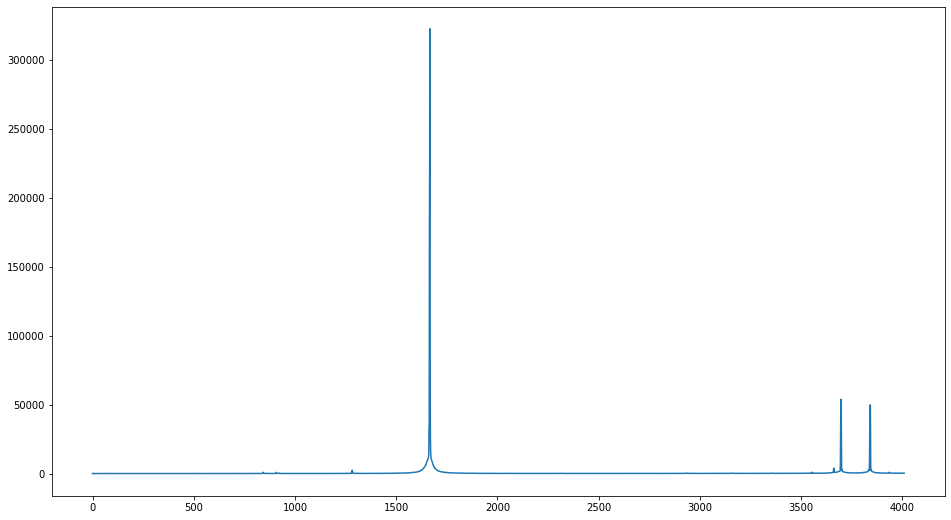

In [4]:
ccd = CCDData.read(_file, unit='adu')

fig, ax = plt.subplots(figsize=(16,9))
ax.plot(ccd.data)

In [5]:
from goodman_pipeline.core import get_lines_in_lamp, get_spectral_characteristics

Cannot load backend 'Qt5Agg' which requires the 'qt5' interactive framework, as 'headless' is currently running


In [6]:
lines = get_lines_in_lamp(ccd=ccd)

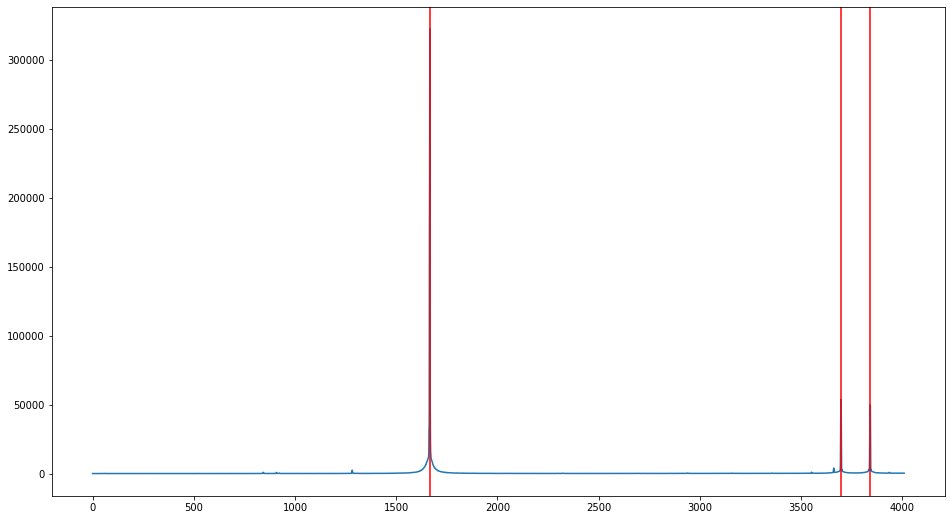

In [7]:
fig_2, ax_2 = plt.subplots(figsize=(16,9))
ax_2.plot(ccd.data)
for _line in lines:
    ax_2.axvline(_line, color='r')

In [8]:
import astropy.units as u
import json
pixel_size = 15 * u.micrometer
goodman_focal_length = 377.3 * u.mm
spec_dict = get_spectral_characteristics(ccd=ccd, pixel_size=pixel_size, instrument_focal_length=goodman_focal_length)

In [9]:
spec_dict

{'center': <Quantity 0.0005577 mm>,
 'blue': <Quantity 5211.45956955 Angstrom>,
 'red': <Quantity 5837.89617764 Angstrom>,
 'alpha': <Quantity 0.62560978 rad>,
 'beta': <Quantity 0.62559193 rad>,
 'pix1': 0,
 'pix2': 0}

In [10]:
print(ccd.data.shape)
spec_dict['center'].to('Angstrom').value

(4010,)


5576.994632141693

In [11]:
from astropy.modeling import models, fitting

x_points_pixel = [0, ccd.data.shape[0]/2., ccd.data.shape[0]]
x_points_angstrom_theoretical = [spec_dict['blue'].value, spec_dict['center'].to('Angstrom').value,spec_dict['red'].value]
x_points_angstrom = [5460.7350, 5769.5980, 5790.6630]

In [12]:
from goodman_pipeline.wcs import WCS
import numpy as np

wcs = WCS()

theoretical_solution = wcs.fit(physical=x_points_pixel, wavelength=x_points_angstrom_theoretical, model_name='linear')
empirical_solution = wcs.fit(physical=lines, wavelength=x_points_angstrom, model_name='chebyshev', degree=2)
empirical_solution_linear = wcs.fit(physical=lines, wavelength=x_points_angstrom, model_name='linear')

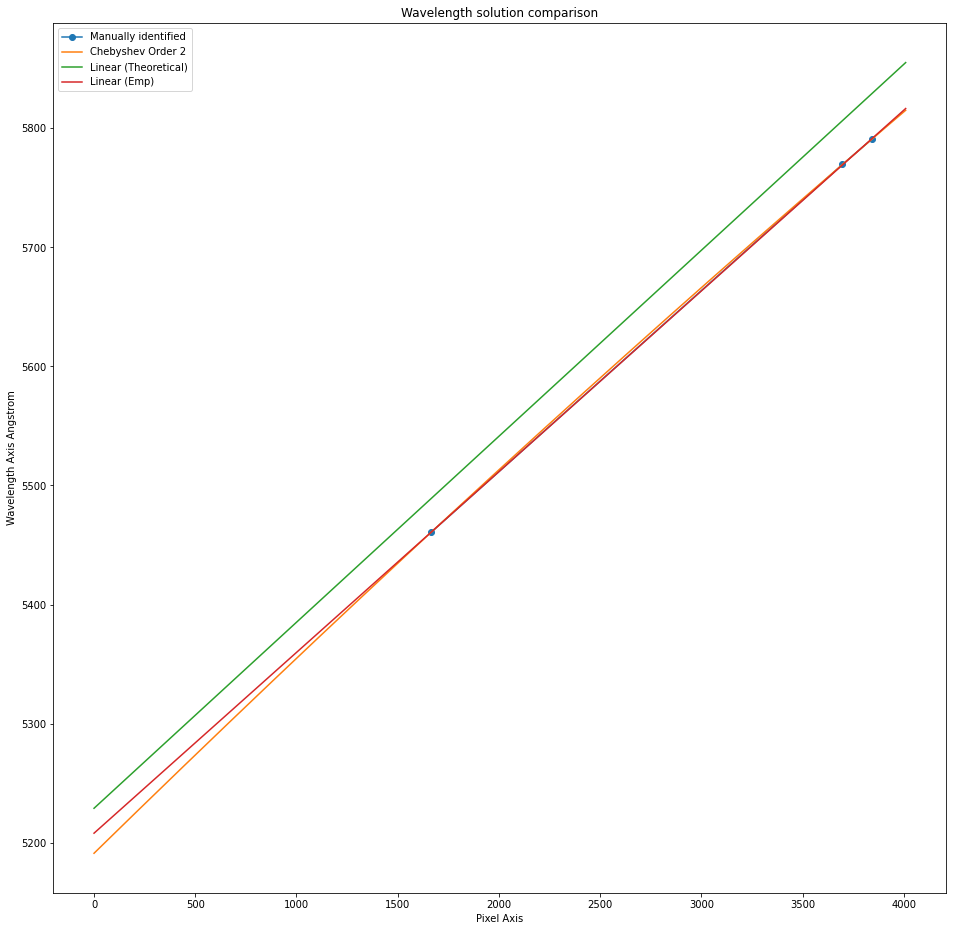

In [13]:
fig, ax = plt.subplots(figsize=(16,16))
# ax.plot(x_points_pixel, x_points_angstrom_theoretical, label='Theoretical')
ax.plot(lines, x_points_angstrom, marker='o', label='Manually identified')
x_axis = range(ccd.data.shape[0])
ax.plot(x_axis, empirical_solution(x_axis), label="Chebyshev Order 2")
ax.plot(x_axis, theoretical_solution(x_axis), label="Linear (Theoretical)")
ax.plot(x_axis, empirical_solution_linear(x_axis), label="Linear (Emp)")
ax.set_xlabel('Pixel Axis')
ax.set_ylabel('Wavelength Axis Angstrom')
ax.set_title('Wavelength solution comparison')
ax.legend(loc='best')

plt.savefig('solution_comparison.png')

In [14]:
def add_matched_line_record(ccd, pixels, angstrom):
    if len(pixels) == len(angstrom):
        last_added = 'GSP_WREJ'
        for i in range(len(pixels)):
            keyword_name = f"GSP_P{i + 1:03}"
            ccd.header.set(keyword_name, 
                           value=pixels[i], 
                           comment="Line location in pixel value",
                           after=last_added)
            last_added = keyword_name
        for i in range(len(angstrom)):
            keyword_name = f"GSP_A{i + 1:03}"
            ccd.header.set(keyword_name, 
                           value=angstrom[i], 
                           comment="Line location in angstrom value",
                           after=last_added)
            last_added = keyword_name
        return ccd

        
ccd = add_matched_line_record(ccd, lines, x_points_angstrom)
ccd = wcs.write_gsp_wcs(ccd, empirical_solution)
new_name = f"goodman_comp_{ccd.header['WAVMODE']}_{ccd.header['FILTER2']}_{'HgArNe'}.fits"
ccd.write(new_name, overwrite=True)
print(new_name)
ccd.header

goodman_comp_2100_5577A_GG455_HgArNe.fits


SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    1 / number of array dimensions                     
NAXIS1  =                 4010                                                  
DATE-OBS= '2021-02-10T08:21:12.066' / DATE-OBS Format: YYYY-MM-DDThh:mm:ss.sss  
DATE    = '2021-02-10'         / Date Format is YYYY-MM-DD                      
TIME    = '08:21:12.066 to 08:21:13.069' / ~ Start & Stop of Exposure           
N_PRM0  =                   59 / Status                                         
PG0_0   =                24624 / Camera Flags,                                  
PG0_1   =           518433.220 / Camera Up Time, HH:MM:SS.sss                   
PG0_2   =                    0 / Continuous Clear Mode,                         
PG0_3   =                4.476 / Frame Clear Time, HH:MM:SS.sss                 
PG0_4   =                4.4

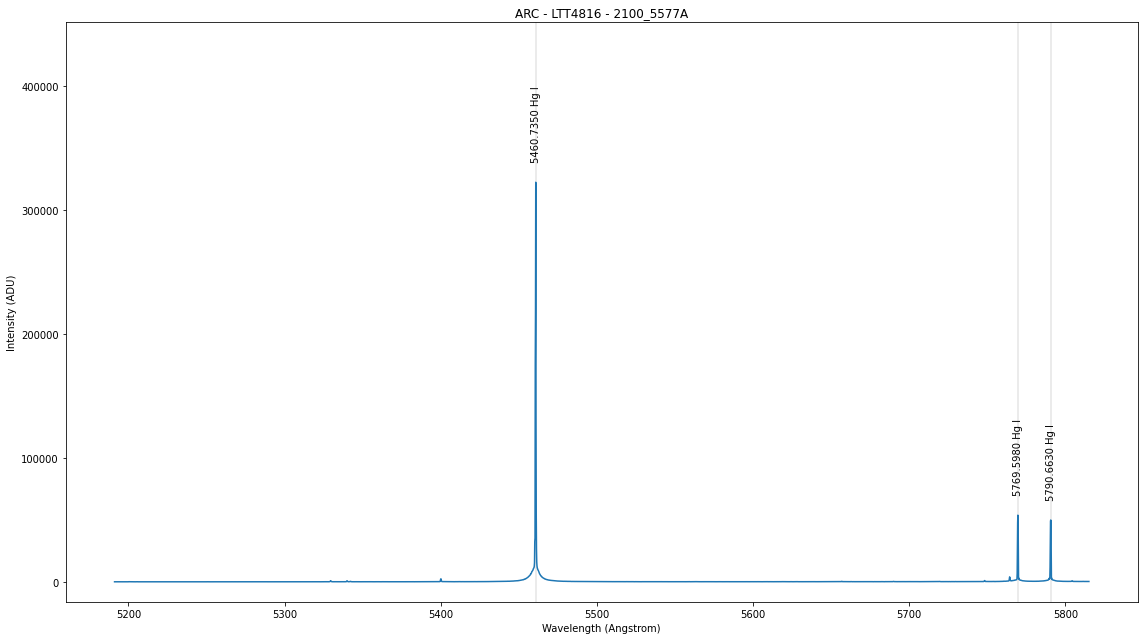

In [15]:
fig3, ax3 = plt.subplots(figsize=(16, 9))

ax3.set_title(f"{ccd.header['OBSTYPE']} - {ccd.header['OBJECT']} - {ccd.header['WAVMODE']}")
top_limit = 1.4 * ccd.data.max()
bottom_limit = ccd.data.min() - 0.05 * ccd.data.max()
ax3.set_ylim(bottom_limit, top_limit)
for _line in lines:
    ax3.axvline(empirical_solution(_line), color='k', alpha=0.1)
    text = f"{empirical_solution(_line):.4f} Hg I"
    text_x = empirical_solution(_line)
    text_y = np.max((ccd.data[int(np.floor(_line))], ccd.data[int(np.ceil(_line))]))
    y_offset = 0.05 * ccd.data.max()
    
    ax3.text(text_x, text_y + y_offset, text, rotation=90, verticalalignment='bottom', horizontalalignment='center')
ax3.plot(empirical_solution(range(ccd.data.shape[0])), ccd.data)
ax3.set_ylabel('Intensity (ADU)')
ax3.set_xlabel('Wavelength (Angstrom)')
plt.tight_layout()
fig3.savefig('2100_5577A_Grating.pdf')


In [16]:
# 5489.0273 -> 5460.7350 Hg I (5495.874 Ar I)
# 5806.3959 -> 5769.5980 Hg I
# 5828.9028 -> 5790.6630 Hg I